In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import display, clear_output

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


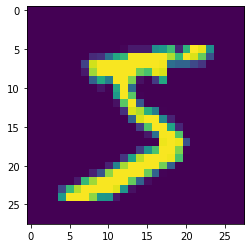

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_valid, y_valid) = mnist.load_data()
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
x_train = x_train.reshape(-1, 28, 28, 1)
x_train = x_train / 127.5 - 1
x_train = np.reshape(x_train,[-1,28,28,1])
plt.imshow(x_train[0,:,:,0])
x_valid = x_valid / 127.5 - 1
x_valid = np.reshape(x_valid,[-1,28,28,1])

In [3]:
batch_size = 32
epoch = 10
lr = 0.0005
num_batches = int(x_train.shape[0]/batch_size)

In [4]:
encoder_input = tf.keras.Input(shape=(28,28,1))

c1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1, 1), padding='SAME', activation='elu', use_bias=True)(encoder_input)
b1 = tf.keras.layers.BatchNormalization()(c1)
m1 = tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(b1)
c2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1, 1), padding='SAME', activation='elu', use_bias=True)(m1)
b2 = tf.keras.layers.BatchNormalization()(c2)
m2 = tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(b2)
c3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), padding='SAME', activation='elu', use_bias=True)(m2)
b3 = tf.keras.layers.BatchNormalization()(c3)

f1 = tf.keras.layers.Flatten()(b3)
d1 = tf.keras.layers.Dense(7*7*128, activation='relu')(f1)
r1 = tf.keras.layers.Reshape(target_shape=[7,7,128])(d1)

c4 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), padding='SAME', activation='elu', use_bias=True)(r1)
b4 = tf.keras.layers.BatchNormalization()(c4)
u1 = tf.keras.layers.UpSampling2D(size = (2,2))(b4)
c5 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1, 1), padding='SAME', activation='elu', use_bias=True)(u1)
b5 = tf.keras.layers.BatchNormalization()(c5)
u2 = tf.keras.layers.UpSampling2D(size = (2,2))(b5)
c6 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1, 1), padding='SAME', activation='elu', use_bias=True)(u2)
b6 = tf.keras.layers.BatchNormalization()(c6)

decoder_output = tf.keras.layers.Conv2D(filters=1, kernel_size=(3,3), strides=(1, 1), activation='tanh', padding='SAME', use_bias=True)(b6)

In [5]:
ae = tf.keras.Model(inputs = encoder_input,outputs = decoder_output)
ae_optimizer = tf.keras.optimizers.Adam(lr)

In [6]:
tr_lossmat = []
val_lossmat = []

In [7]:
start_time = time.time()
for e in range(epoch):
    for b in range(num_batches):
        batch_images = x_train[b*batch_size:(b+1)*batch_size,:,:]
        with tf.GradientTape() as tape:
            ae_pred = ae(batch_images,training = True)
            tr_loss = tf.math.reduce_mean(tf.abs(batch_images-ae_pred))

            gradients = tape.gradient(tr_loss,ae.trainable_variables)
            ae_optimizer.apply_gradients(zip(gradients,ae.trainable_variables))

        valid_ind = np.random.randint(low = 0, high = x_valid.shape[0], size = batch_size)
        valid_set = x_valid[valid_ind,:,:,:]
        valid_loss = tf.math.reduce_mean(tf.abs(valid_set-ae(valid_set,training=False)))
        
        tr_lossmat = np.append(tr_lossmat,[tr_loss],axis=0)
        val_lossmat = np.append(val_lossmat,[valid_loss],axis=0)

        print(f'Epoch : {e+1}', f'Batch number : {b+1}', f'Training Loss : {tr_loss}', f'Validation Loss : {valid_loss}')
        clear_output(wait=True)
end_time = time.time()
print("training time", end_time-start_time)

training time 833.1848847866058


In [16]:
test_ind =  np.random.randint(low = 0, high = x_valid.shape[0], size = 64)
pred_test = x_valid[test_ind,:,:,0]
pred = ae(pred_test,training=False)

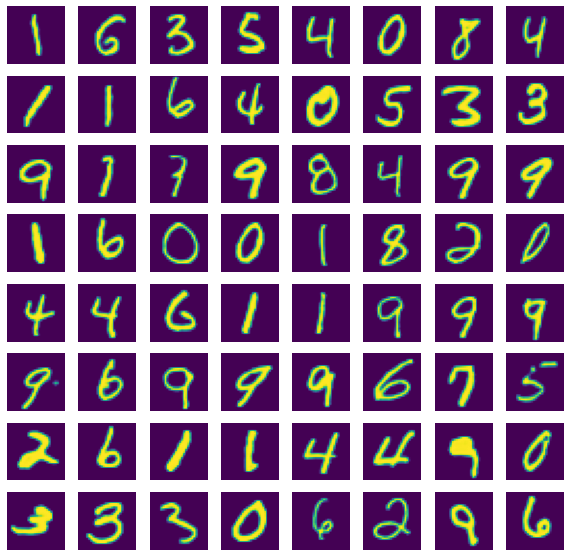

In [17]:
fig = plt.figure(figsize = (10,10))
for i in range(64):
    sp = fig.add_subplot(8,8,i+1)
    t = sp.imshow(pred[i,:,:,0])
    plt.axis('off')

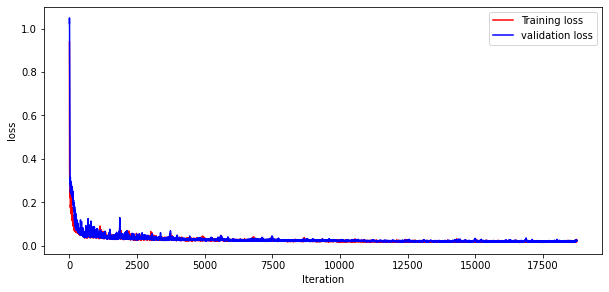

In [18]:
Fig = plt.figure(figsize=(10,10))
ax = Fig.add_subplot(2,1,1)
line_trloss, = ax.plot(tr_lossmat[:],'r-')
line_valloss, = ax.plot(val_lossmat[:],'b-')
ax.set_xlabel('Iteration', Fontsize = 10)
ax.set_ylabel('loss',Fontsize=10)
line_trloss.set_label('Training loss')
line_valloss.set_label('validation loss')
ax.legend()

In [19]:
for i in range(len(ae.layers)):
	layer = ae.layers[i]
	print(i, layer.name, layer.output.shape)

0 input_1 (None, 28, 28, 1)
1 conv2d (None, 28, 28, 32)
2 batch_normalization (None, 28, 28, 32)
3 max_pooling2d (None, 14, 14, 32)
4 conv2d_1 (None, 14, 14, 64)
5 batch_normalization_1 (None, 14, 14, 64)
6 max_pooling2d_1 (None, 7, 7, 64)
7 conv2d_2 (None, 7, 7, 128)
8 batch_normalization_2 (None, 7, 7, 128)
9 flatten (None, 6272)
10 dense (None, 6272)
11 reshape (None, 7, 7, 128)
12 conv2d_3 (None, 7, 7, 128)
13 batch_normalization_3 (None, 7, 7, 128)
14 up_sampling2d (None, 14, 14, 128)
15 conv2d_4 (None, 14, 14, 32)
16 batch_normalization_4 (None, 14, 14, 32)
17 up_sampling2d_1 (None, 28, 28, 32)
18 conv2d_5 (None, 28, 28, 32)
19 batch_normalization_5 (None, 28, 28, 32)
20 conv2d_6 (None, 28, 28, 1)


In [20]:
model_vis = tf.keras.Model(inputs=ae.inputs, outputs=ae.layers[18].output)

(1, 28, 28, 32)


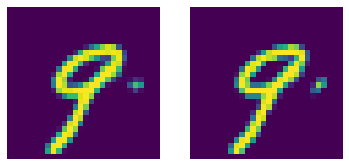

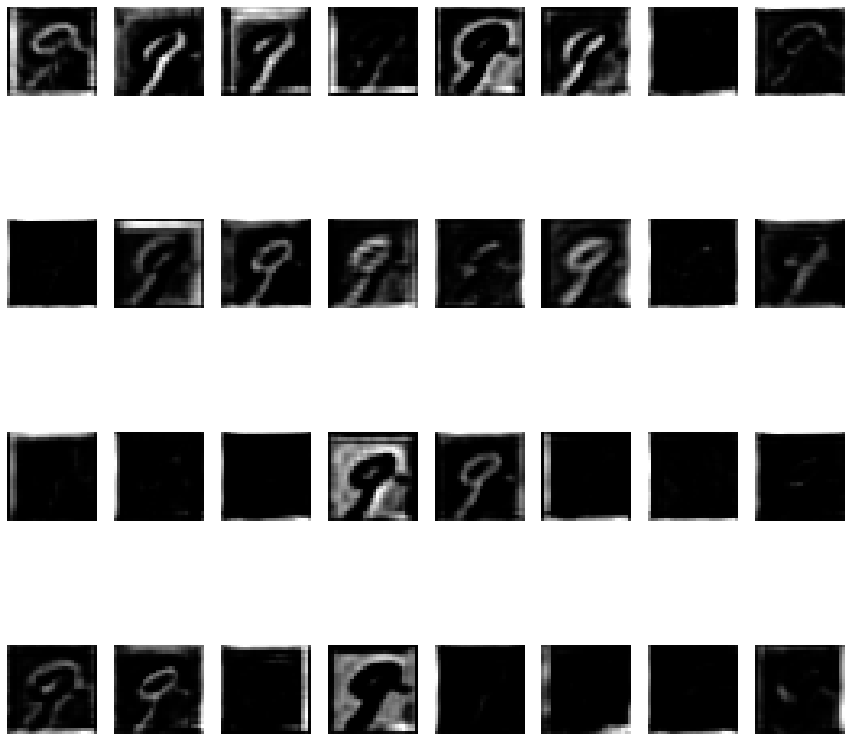

In [29]:
ts = np.random.randint(low=0,high=pred.shape[0])
test_samples = pred[ts:ts+1,:,:]
Fig = plt.figure()
Fig.add_subplot(1,2,1)
plt.imshow(test_samples[0,:,:,0])
plt.axis('off')
Fig.add_subplot(1,2,2)
plt.imshow(pred_test[ts,:,:])
plt.axis('off')
feature_maps = model_vis.predict(test_samples)
print(feature_maps.shape)
fig = plt.figure(figsize =(15,15))
for i in range(32):
    sp = fig.add_subplot(4,8,i+1)
    sp.imshow(feature_maps[0,:,:,i], cmap='gray')
    sp.axis('off')